In [1]:
import tkinter as tk
from tkinter import ttk
import pandas as pd

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import (
            FigureCanvasTkAgg, NavigationToolbar2Tk)
import matplotlib.pyplot as plt
from tkinter import filedialog as fd 
from tkinter import messagebox as mb

In [71]:
class coverslip():
    def __init__(self, logfile, exp_params):
        self.log_file = logfile
        self.exp_params = exp_params


    def process_coverslip(self):
        self.__load_FURA_log()
        self.clean_raw_data()
        self.get_metrics()
        self.get_delta_ratio()
        self.determine_responsive()

        self.cs_name = self.log_file.split('/')[-1]
        self.cs_name = self.cs_name.split('.')[0]

    

    def set_params(self, params):
        self.exp_params = params;
        self.__clean_raw_data()
        self.__get_metrics()
        self.__get_delta_ratio()
        self.__determine_responsive()



    def __load_FURA_log(self):

        f = open(self.log_file, "r")
        dat = f.read()
        f.close()

        split_dat = dat.split('\n')
        
        if 'File' in split_dat[0]:
            file_name = split_dat[0].split(': ')[1][:-1]

        if 'Date' in split_dat[1]:
            date = split_dat[1].split(': ')[1][:-1]


        regions = [line for line in split_dat if line.startswith('"Region')]
        number_ROIs = len(regions)


        if number_ROIs == 0:
            print("No header in file")
            num_dat = [sub.split(",") for sub in split_dat[2:]]
            data_table = pd.DataFrame(num_dat, dtype = float)
            self.regions = [];

        else:
            self.regions = self.get_region_table(regions)
            column_names = [split_dat[number_ROIs+2].split(', ')][0]
            cn = [n.replace('"', '') for n in column_names]
            roi_id = [n.split(" ",1)[0] for n in cn]
            data_id = [n.split(" ",1)[1] for n in cn]

            num_dat = [sub.split(",") for sub in split_dat[(number_ROIs+3):]]
            data_table = pd.DataFrame(num_dat, columns = cn, dtype = float) 
        
        self.datafile = file_name
        self.date = date
        self.log_data = data_table


    def get_region_table(self, regions):

        col_names = ["Region", "Location X", "Location Y", "Size X", "Size Y", "Area"]
        region_data = [re.findall(r'\d+', ROI) for ROI in regions]
        region_table = pd.DataFrame(region_data, columns= col_names)
        return region_table

    def clean_raw_data(self):

        ratio_dat = self.log_data.iloc[:,3::3]

        ratio_dat.iloc[:,0] = ratio_dat.iloc[:,0].fillna(0)
        
        ratio_dat.columns = [x  for x in range(len(ratio_dat.columns))]
        time = self.log_data.iloc[:,0];
        delta_time = time - time[0];

        
        ratio_dat.insert(0, 'Time', time)
        ratio_dat.insert(1, 'Elapsed', delta_time)


        id_values = [n for (a,n) in zip(self.exp_params['lp_frames'], self.exp_params['ids']) for x in range(a)]

        if len(id_values) < len(ratio_dat):
            added = len(ratio_dat) - len(id_values)
            [id_values.append("None") for x in range(added)]
            
            if added > 10:
                mb.showwarning(message = 'Experiment is '+str(added/10)+ ' minutes longer than parameters indicate')


                

        if len(id_values) > len(ratio_dat):
            raise Exception("Parameters indicate longer experiment than data given")
    
        ratio_dat.insert(2, 'LP', id_values)
        ratio_dat = ratio_dat.drop(0, axis = 1)

        self.ratio_dat = ratio_dat
        

    def get_metrics(self):

        grouped = self.ratio_dat.iloc[:,2:].groupby('LP', sort = False)
        
        mean_val = grouped.mean()
        
        max_val = grouped.max()
        min_val = grouped.min()


        metrics_dat = pd.DataFrame(columns = self.ratio_dat.columns[3:])
        
        for m,n in zip(self.exp_params['metrics'], self.exp_params['ids']):
            
    
            if m == 2:
                metrics_dat.loc[n] = mean_val.loc[n]
                
            
            if m == 1:
                metrics_dat.loc[n] = min_val.loc[n]
            
            if m == 3:
                metrics_dat.loc[n] = max_val.loc[n]
        
        

        self.delta_dat = (metrics_dat- metrics_dat.iloc[0])/metrics_dat.iloc[0]
        self.metrics_dat = metrics_dat
        
    
    def get_delta_ratio(self): 

        grouped = self.ratio_dat.iloc[:,2:].groupby('LP', sort = False)
        mean_val = grouped.mean()
       
        drr = self.ratio_dat.copy()
        drr = drr.drop('Elapsed', axis = 1)
        drr = drr.drop('LP', axis = 1)
        drr = drr.drop('Time', axis = 1)
        
       
        drr = (drr - mean_val.iloc[0,:])/(mean_val.iloc[0,:])
  
    
        self.drr = drr
    
    def determine_responsive(self):


        thresh_check = np.array(self.exp_params['tc'])
        tc = np.array(self.exp_params['ids'])[thresh_check > 0]
        tv = np.array(self.exp_params['threshold'])[thresh_check > 0]
        tr = np.array(self.exp_params['ratio'])[thresh_check > 0]
        td = np.array(self.exp_params['direction'])[thresh_check > 0]

        boo_table = pd.DataFrame(columns = self.metrics_dat.columns)
        for c,v,r,d in zip(tc,tv,tr,td):
            
            if r == 1:
                dat = self.metrics_dat.loc[c]
            elif r == -1:
                dat = self.delta_dat.loc[c]
            else:
                dat = self.delta_dat.loc[c]
            
            if d == 1:
                #boo_array.append(dat < v)
                boo_table.loc[c] = dat > v
            
            elif d == -1:
                #boo_array.append(dat > v)
                boo_table.loc[c] = dat < v


        a = [n for (n,c) in zip(self.exp_params['ids'], self.exp_params['chooser']) if c == 1]
        boo_table.loc['Good_ROIs'] = boo_table.loc[a,:].all()

        self.responsive = boo_table
    
    def output_responsive_data(self):
        
        sub_select = self.responsive & self.responsive.loc['Good_ROIs']

        totals = sub_select.sum(axis = 1)
        percents = (totals/totals[-1])*100

                
        mets = [self.metrics_dat.loc[a, sub_select.loc[a]].mean() for a in sub_select.index[:-1]];

        delts = [self.delta_dat.loc[a, sub_select.loc[a]].mean() for a in sub_select.index[:-1]];
        
                
        responsive_data = pd.DataFrame({'Count': totals[:-1], 'Percent': percents[:-1], 'Ratio': mets, 'Delta R': delts})
        return responsive_data
        


    def output_dat_table(self):

        boo_array = self.responsive.loc['Good_ROIs']
        md = self.metrics_dat.loc[:, boo_array]
        dd = self.delta_dat.loc[:, boo_array]
        
        

        metrics_table = pd.DataFrame({'Mean': md.mean(axis = 1), 'Median': md.median(axis = 1), 'STDev': md.std(axis = 1), 
                                    'SEM' : md.sem(axis = 1), 'Min' : md.min(axis = 1), 'Max' : md.max(axis = 1)})

        delta_table = pd.DataFrame({'Mean': dd.mean(axis = 1), 'Median': dd.median(axis = 1), 'STDev': dd.std(axis = 1), 
                                'SEM' : dd.sem(axis = 1), 'Min' : dd.min(axis = 1), 'Max' : dd.max(axis = 1)})   


        return metrics_table, delta_table
    

    def save_data_as_excel(self):
        
        file_path = fd.asksaveasfilename(
            defaultextension=".xlxs",
            filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")),
            initialfile=self.cs_name + ".xlsx",
            title="Save As"
        )

        
         
        #new_fn = self.log_file.split('/')[-1]
        #new_fn2 = new_fn.split('.')[0]
        #full_path = path+ '/' +self.cs_name + '.xlsx'


        boo_array = (self.responsive.sum()/len(self.responsive)) == 1
        mt, dt = self.output_dat_table()

        met = []
        for m in self.exp_params['metrics']:
            if m == 2:
                met.append("Mean")
            if m == 1:
                met.append("Min")
            if m == 3:
                met.append("Max")

        mt.insert(0, 'Metric', met)
        dt.insert(0, 'Metric', met)

        metrics = self.metrics_dat.copy()
        metrics.insert(0, 'Metric', met)

        delta = self.delta_dat.copy()
        delta.insert(0, 'Metric', met)

        resp = self.output_responsive_data()

        with pd.ExcelWriter(file_path, mode="w", engine="openpyxl") as writer:
            if len(self.regions) > 0:
                self.regions.to_excel(writer, sheet_name = 'ROI Information')
            self.log_data.to_excel(writer, sheet_name = 'Raw Data')
            self.ratio_dat.to_excel(writer, sheet_name = 'Ratio Data')
            self.drr.to_excel(writer, sheet_name = 'Delta R over R')
            resp.to_excel(writer, sheet_name = 'Responsive Data')
            mt.to_excel(writer, sheet_name= 'Responsive Ratios')
            dt.to_excel(writer, sheet_name='Responsive Delta Rs')
            metrics.to_excel(writer, sheet_name = 'Metrics Ratios')
            delta.to_excel(writer, sheet_name = 'Metrics Delta R')
            self.responsive.to_excel(writer, sheet_name = 'Responsive')

            
    def plot_ratio(self, av, shadecolor = 'blue'):

        fig1, axs1 = plt.subplots(1,1)
        fig1.set_size_inches(8,4)
        frames = np.cumsum(self.exp_params['lp_frames']).copy()
        
        if 0 not in frames:
            frames = np.append(0, frames)
        

        ts =  self.exp_params['ids']
        if 'End' not in ts:
            ts.append('End')

        
        t = self.ratio_dat.loc[self.ratio_dat['LP'] != 'None', 3:]
        t = t.loc[:,self.responsive.loc['Good_ROIs']]


        if av == 0:
            t.plot(legend = False, ax = axs1)
        else:
            y = t.mean(axis = 1)
            error = t.sem(axis = 1)


            x = np.linspace(0, len(y)-1, len(y))
            axs1.plot(x,y, 'k-')
            axs1.fill_between(x, y-error, y+error, color = shadecolor, alpha = 0.3)
            


        #name = self.log_file.split('/')[-1]
        axs1.set_title(self.cs_name + " Ratios")

        for a in frames:
            axs1.axvline(x = a, color = 'k', label = 'axvline - full height', linestyle = ':')

        axs1.set_xticks(frames)
        axs1.set_xticklabels(ts)
        axs1.set_ylabel('340/380')

        self.ratio_fig = fig1
        return self.ratio_fig
    
    
    def plot_delta(self, av, shadecolor = 'blue'):

        fig2, axs2 = plt.subplots(1,1)
        fig2.set_size_inches(8,4)
        frames = np.cumsum(self.exp_params['lp_frames']).copy()
        
        if 0 not in frames:
            frames = np.append(0, frames)
        

        ts =  self.exp_params['ids']
        if 'End' not in ts:
            ts.append('End')


        t = self.drr.loc[self.ratio_dat['LP'] != 'None', self.responsive.loc['Good_ROIs']]
        
        
        #y = self.drr.loc[self.ratio_dat['LP'] != 'None',self.responsive.loc['Good_ROIs']]
        if av == 0:
            t.plot(legend = False, ax = axs2)
        else:
            y = t.mean(axis = 1)
            error = t.sem(axis = 1)


            x = np.linspace(0, len(y)-1, len(y))
            axs2.plot(x,y, 'k-')
            axs2.fill_between(x, y-error, y+error,color = shadecolor,  alpha = 0.3)
            

        #name = self.log_file.split('/')[-1]
        axs2.set_title(self.cs_name + " Delta Ratio")

        for a in np.cumsum(self.exp_params['lp_frames']):
            axs2.axvline(x = a, color = 'k', label = 'axvline - full height', linestyle = ':')

        axs2.set_xticks(frames)
        axs2.set_xticklabels(ts)
        axs2.set_ylabel('∆R/R')
        self.delta_fig = fig2

        return self.delta_fig
    

    
    def save_coverslip_plot(self, lims, path):
        

        lim_check = all(a == 0 for a in lims)
        if len(path)> 0 : 

            full_path_ratio1 = path+ '_ratio.png'
            full_path_delta1 = path+ '_delta.png'

            f1 = self.plot_ratio(0)
            if not lim_check:
                ax = f1.gca()
                ax.set_ylim(lims[0], lims[1])
              
            plt.savefig(full_path_ratio1)

            f2 = self.plot_delta(0)
            if not lim_check:
                ax = f2.gca()
                ax.set_ylim(lims[2], lims[3])
                
            plt.savefig(full_path_delta1)

            full_path_ratio2 = path+  '_ratio_average.png'
            full_path_delta2 = path+ '_delta_average.png'

            f3 = self.plot_ratio(1)
            if not lim_check:
                ax = f3.gca()
                ax.set_ylim(lims[0], lims[1])
              
            plt.savefig(full_path_ratio2)

            f4 = self.plot_delta(1)
            if not lim_check:
                ax = f4.gca()
                ax.set_ylim(lims[2], lims[3])
                
            plt.savefig(full_path_delta2)

In [72]:
class experiment(coverslip):

    def __init__(self, logfiles, exp_params, name):
        super().__init__(logfiles, exp_params)
        self.cs_name = name
        
    def process_experiment(self):
        self.__load_FURA_logs()
        super().clean_raw_data()
        super().get_metrics()
        super().get_delta_ratio()
        super().determine_responsive()
        

    def __load_FURA_logs(self):

        log_list = []
        self.regions = []

        for logfile in self.log_file:
            
            f = open(logfile, "r")
            dat = f.read()
            f.close()

            split_dat = dat.split('\n')
            
            if 'File' in split_dat[0]:
                file_name = split_dat[0].split(': ')[1][:-1]

            if 'Date' in split_dat[1]:
                date = split_dat[1].split(': ')[1][:-1]


            regions = [line for line in split_dat if line.startswith('"Region')]
            number_ROIs = len(regions)


            if number_ROIs == 0:
                print("No header in file")
                num_dat = [sub.split(",") for sub in split_dat[2:]]
                data_table = pd.DataFrame(num_dat, dtype = float)

            else:
                region_table = self.get_region_table(regions)

                if len(self.regions) == 0:
                    self.regions = region_table
                else:
                    self.regions.append(region_table)

                column_names = [split_dat[number_ROIs+2].split(', ')][0]
                cn = [n.replace('"', '') for n in column_names]
                roi_id = [n.split(" ",1)[0] for n in cn]
                data_id = [n.split(" ",1)[1] for n in cn]

                num_dat = [sub.split(",") for sub in split_dat[(number_ROIs+3):]]
                data_table = pd.DataFrame(num_dat, columns = cn, dtype = float) 
            
            if len(log_list) == 0:
                log_list.append(data_table)
            else:
                log_list.append(data_table.iloc[:,1:])
        
            self.log_data = pd.concat(log_list, axis = 1)

In [73]:
class LP_frame(tk.Frame):
    def __init__(self, parent, num):

        super().__init__(parent)

        title_label = tk.Label(self, text = 'Liquid Period '+ str(num+1), font=("Arial Bold", 12))
        self.name_var = tk.StringVar()

        name_label = tk.Label(self, text = 'LP Name')
        name_entry = tk.Entry(self,textvariable = self.name_var, width = 15)

        self.time_var = tk.IntVar()
        time_label = tk.Label(self, text = 'Duration (mins)')
        time_entry = tk.Entry(self, textvariable = self.time_var, width = 2)

        self.measurement = tk.IntVar()
        self.measurement.set(2)
        measurement_label = tk.Label(self, text = 'Measurement')
        M1 = tk.Radiobutton(self, text="Min", variable=self.measurement, value=1)
        M2 = tk.Radiobutton(self, text="Mean", variable=self.measurement, value=2)
        M3 = tk.Radiobutton(self, text="Max", variable=self.measurement, value=3)


        self.thresh_check = tk.IntVar()
        self.thresh_check.set(0)
        c1 = tk.Checkbutton(self, text='Threshold',variable= self.thresh_check, onvalue=1, offvalue=0)
        


        self.direction = tk.IntVar()
        self.direction.set(1)
        D1 = tk.Radiobutton(self, text=">", variable=self.direction, value=1)
        D2 = tk.Radiobutton(self, text="<", variable=self.direction, value=-1)

        self.ratio = tk.IntVar()
        self.ratio.set(-1)
        D3 = tk.Radiobutton(self, text="Ratio", variable=self.ratio, value= 1)
        D4 = tk.Radiobutton(self, text="DR/R", variable=self.ratio, value= -1)
        
        self.thresh = tk.DoubleVar()
        thresh_entry = tk.Entry(self, textvariable = self.thresh, width = 4)

        self.chooser = tk.IntVar()
        self.chooser.set(0)
        c2 = tk.Checkbutton(self, text='ROI Select',variable= self.chooser, onvalue=1, offvalue=0)  
        #chooser_label = tk.Label(self, text = 'Measurement')
        
        separator = ttk.Separator(self, orient='horizontal')


        title_label.grid(row = 0, column = 0)
        name_label.grid(row=1,column=0, columnspan = 2)
        name_entry.grid(row=1,column=2, columnspan = 3)

        time_label.grid(row=2,column=0, columnspan= 2)
        time_entry.grid(row=2,column=2)

        measurement_label.grid(row = 3, column = 0, sticky = 'E', columnspan= 2)
        M1.grid(row = 3, column= 3,sticky = 'W')
        M2.grid(row =3, column = 4, sticky = 'W')
        M3.grid(row = 3, column = 5, sticky = 'W')

        c1.grid(row = 4, column = 0)
        D3.grid(row = 4, column= 2, sticky = 'W')
        D4.grid(row =4, column = 3, sticky = 'W')
        D1.grid(row = 4, column = 4, sticky = 'W')
        D2.grid(row = 4, column = 5, sticky = 'W')
        thresh_entry.grid(row =4, column = 6,sticky = 'W')

        c2.grid(row = 5, column = 0)

        separator.grid(row =6, column = 0, columnspan = 7, sticky = 'ew')

        

    def get(self):
        data = {'name': self.name_var.get(), 'time': self.time_var.get(), 'measurement': self.measurement.get(),
                'direction': self.direction.get(), 'threshold': self.thresh.get(), 'thresh_check': self.thresh_check.get(), 
                'ratio': self.ratio.get(), 'chooser': self.chooser.get()}
    
        return data
   

    def set_data(self, data_dict):
        self.name_var.set(data_dict['name'])
        self.time_var.set(data_dict['time'])
        self.measurement.set(data_dict['measurement'])
        self.direction.set(data_dict['direction'])
        self.thresh.set(data_dict['threshold'])
        self.thresh_check.set(data_dict['thresh_check'])
        self.ratio.set(data_dict['ratio'])
        self.chooser.set(data_dict['chooser'])





In [74]:
class main_window(tk.Toplevel):

    def __init__(self, root, exp_name = 'default', *args, **kwargs):
        super().__init__(root, *args, **kwargs)

        
        self.wm_title("Fura-2 Analysis")
        self.exp_name = exp_name
        
        top_frame = tk.Frame(self)
        top_frame.pack(side="top", fill="both", expand=True)


        lps_label = tk.Label(top_frame, text = 'Enter LP #')
        self.lps = tk.IntVar()
        lps_entry = tk.Entry(top_frame ,textvariable = self.lps, width = 2)
        lps_button =tk.Button(top_frame, text="Submit", command = self.populate_LPs)
        load_param_button = tk.Button(top_frame, text = 'Load Parameter File', command = self.load_parameters)
        save_param_button = tk.Button(top_frame, text = 'Save Current Parameters', command = self.save_parameters)

        lps_label.grid(row = 0, column = 0)
        lps_entry.grid(row = 0, column = 1)
        lps_button.grid(row = 0, column = 2)
        load_param_button.grid(row = 0, column = 3)
        save_param_button.grid(row = 0, column = 4)

        top_frame.pack()

        button_frame = tk.Frame(self)

        load_button = tk.Button(button_frame, text = "Load Files", command = self.load_file)
        cal_button = tk.Button(button_frame, text="Calculate Responses",  command = self.get_data)
        save_res_button = tk.Button(button_frame, text = 'Save Responses',  command = self.save_data)
        plot_button = tk.Button(button_frame, text="Plot Data", command = self.plot_data)
        save_plot_button = tk.Button(button_frame, text = 'Save Plots' , command = self.save_plots)


        load_button.pack(side = 'left')
        cal_button.pack(side = 'left')
        save_res_button.pack(side = 'left')
        plot_button.pack(side = 'left')
        save_plot_button.pack(side = 'left')


        button_frame.pack()

        
        #container = ttk.Frame(self)
        canvas = tk.Canvas(self, height = 600, width = 400)
        scrollbar = ttk.Scrollbar(self, orient="vertical", command=canvas.yview)
        self.scrollable_frame = ttk.Frame(canvas)

        self.scrollable_frame.bind(
            "<Configure>",
            lambda e: canvas.configure(
                scrollregion=canvas.bbox("all")
            )
        )
        canvas.create_window((0, 0), window=self.scrollable_frame, anchor="nw")
        canvas.configure(yscrollcommand=scrollbar.set)

        #container.pack(side="left", fill="both", expand=False)
        canvas.pack(side="left", fill="both", expand=True)
        scrollbar.pack(side="right", fill="y")

        
        self.all_frames = [];
        self.file_path = [];



    def populate_LPs(self):

        if len(self.all_frames) != 0:
            for f in self.all_frames:
                f.destroy()
                self.all_frames = []

            
        for i in range(self.lps.get()):
            f = LP_frame(self.scrollable_frame, i)
            f.pack(side = 'top')
            self.all_frames.append(f)
    

    def load_file(self):

        dialog = tk.Tk()
        
        dialog.call('wm', 'attributes', '.', '-topmost', True)
        self.file_path = fd.askopenfilenames()
        dialog.destroy()


    def get_params(self):
        df = pd.DataFrame([a.get() for a in self.all_frames])


        LP_length = list(df['time'])
        sample_rate = 10
        LP_IDs = list(df['name'])
        metrics = list(df['measurement'])
        thresholds = list(df['threshold'])
        direction = list(df['direction'])
        tc = list(df['thresh_check'])
        r = list(df['ratio'])
        c = list(df['chooser'])

        lp_frames = [i * sample_rate for i in LP_length]
        exp_params = {"lp_frames":lp_frames, "sample_rate":sample_rate, "ids":LP_IDs, "metrics": metrics, "threshold": thresholds, 
                        "direction": direction, 'ratio': r, 'tc': tc, 'chooser': c}
        
        return exp_params
    
    def pdtotk(self, df, tk_root):

        df = df.reset_index().rename(columns={'index': 'LP'})

        tree = ttk.Treeview(tk_root, show='headings')
        pd.set_option('display.float_format', lambda x: '%.2f' % x)

        df = df.round(2)
        # add columns to the Treeview widget
        tree['columns'] = list(df.columns)

        # format columns
        for col in df.columns:
            tree.column(col, width=100, anchor='center')
            tree.heading(col, text=col)

        # add rows to the Treeview widget
        for index, row in df.iterrows():
            tree.insert('', index, values=list(row))

        # pack the Treeview widget and start the tkinter mainloop
        tree.pack(fill='both', expand=True)
        tree.pack_propagate(False)

    def get_data(self):
        
        if len(self.file_path) == 0:
            mb.showwarning(message = 'No log file imported')
        elif len(self.all_frames) == 0:
            mb.showwarning(message = 'No parameters set')
        else:
            exp_params = self.get_params()
            
            
                
            exp_params = self.get_params()
            
            #for fn in self.file_path:
            
            if len(self.file_path) == 1:
                cs = coverslip(self.file_path[0], exp_params)
                cs.process_coverslip()
                self.all_cs = cs
            else:
                cs = experiment(self.file_path, exp_params, self.exp_name)
                cs.process_experiment()
                self.all_cs = cs

        

            newWindow = tk.Toplevel(self)
            #name_title = fn.split('/')[-1]
            #newWindow.title(name_title)

            all_resp_title = tk.Label(newWindow, text = 'Responsive Data',  font=("Arial Bold", 12))
            all_resp_frame = tk.Frame(newWindow)

            resp_df = cs.output_responsive_data()

            self.pdtotk(resp_df, all_resp_frame)

            mt, dt = cs.output_dat_table()
            

            metrics_title = tk.Label(newWindow, text = 'Summary Stats: Ratios', font=("Arial Bold", 12) )
            metrics_frame = tk.Frame(newWindow)
            self.pdtotk(mt, metrics_frame)

            metrics_text = tk.Label(newWindow, text = mt.to_string())
            delta_title = tk.Label(newWindow, text = 'Summary Stats: Delta R/R' , font=("Arial Bold", 12))
            delta_frame = tk.Frame(newWindow)
            self.pdtotk(dt, delta_frame)

            all_resp_title.pack(side = 'top')
            all_resp_frame.pack(side = 'top')
            
            metrics_title.pack(side = 'top')
            metrics_frame.pack(side = 'top')
            delta_title.pack(side = 'top')
            delta_frame.pack(side = 'top')
                
    
    def save_data(self):


        #path = fd.askdirectory()
        if len(self.file_path) == 0:
            mb.showwarning(message = 'No log file imported')
        elif len(self.all_frames) == 0:
            mb.showwarning(message = 'No parameters set')
        else:
            
            self.all_cs.save_data_as_excel()
                
                        
    def plot_data(self):

        if len(self.file_path) == 0:
            mb.showwarning(message = 'No log file imported')
        elif len(self.all_frames) == 0:
            mb.showwarning(message = 'No parameters set')
        else:
            
            askWindow = tk.Toplevel(self)
            askWindow.title("Input y axis limits")

            bottom_ratio_label = tk.Label(askWindow, text = 'Lower Limit (ratio): ')
            self.bottom_ratio = tk.DoubleVar()
            bottom_ratio_entry = tk.Entry(askWindow ,textvariable = self.bottom_ratio, width = 2)

            top_ratio_label = tk.Label(askWindow, text = 'Upper Limit (ratio):  ')
            self.top_ratio = tk.DoubleVar()
            top_ratio_entry = tk.Entry(askWindow ,textvariable = self.top_ratio, width = 2)


            bottom_delta_label = tk.Label(askWindow, text = 'Lower Limit (delta): ')
            self.bottom_delta = tk.DoubleVar()
            bottom_delta_entry = tk.Entry(askWindow ,textvariable = self.bottom_delta, width = 2)

            top_delta_label = tk.Label(askWindow, text = 'Upper Limit (delta):  ')
            self.top_delta = tk.DoubleVar()
            top_delta_entry = tk.Entry(askWindow ,textvariable = self.top_delta, width = 2)

           
            self.average = tk.IntVar()
            av_check = tk.Checkbutton(askWindow, text='Average',variable= self.average, onvalue=1, offvalue=0)  
            
            #self.lims = [bottom_ratio.get(), top_ratio.get(), bottom_delta.get(), top_delta.get()];
            enter_button =tk.Button(askWindow, text="Submit", command = self.all_plots)

            bottom_ratio_label.grid(row = 0, column = 0)
            bottom_ratio_entry.grid(row = 0, column = 1)

            top_ratio_label.grid(row = 1, column = 0)
            top_ratio_entry.grid(row = 1, column = 1)

            bottom_delta_label.grid(row = 2, column = 0)
            bottom_delta_entry.grid(row = 2, column = 1)

            top_delta_label.grid(row = 3, column = 0)
            top_delta_entry.grid(row = 3, column = 1)
            av_check.grid(row =4, column = 1)

            enter_button.grid(row = 5, columnspan = 2)


            
            

    def all_plots(self):
        lims = [self.bottom_ratio.get(), self.top_ratio.get(), self.bottom_delta.get(), self.top_delta.get()]
        lim_check = all(a == 0 for a in lims)

      
        f1 = self.all_cs.plot_ratio(self.average.get())
        print(self.average.get())
        if not lim_check:
            ax = f1.gca()
            ax.set_ylim(lims[0], lims[1])
            self.all_cs.ratio_fig = f1

        newWindow1 = tk.Toplevel(self)
        newWindow1.title(self.all_cs.log_file)
        canvas1 = FigureCanvasTkAgg(f1, master = newWindow1)  
        canvas1.draw()
        canvas1.get_tk_widget().pack()

        

        f2 = self.all_cs.plot_delta(self.average.get())
        if not lim_check:
            ax = f2.gca()
            ax.set_ylim(lims[2], lims[3])

            self.all_cs.delta_fig = f2

        newWindow2 = tk.Toplevel(self)
        newWindow2.title(self.all_cs.log_file)
        canvas2 = FigureCanvasTkAgg(f2, master = newWindow2)  
        canvas2.draw()
        canvas2.get_tk_widget().pack()

            
    

    def save_plots(self):

        
        lims = [self.bottom_ratio.get(), self.top_ratio.get(), self.bottom_delta.get(), self.top_delta.get()]

        path = fd.asksaveasfilename(
            initialfile= self.all_cs.cs_name,
            title="Save As"
        )   
        self.all_cs.save_coverslip_plot(lims, path)

            


    def load_parameters(self):

        #dialog = tk.Tk()
        
        #dialog.call('wm', 'attributes', '.', '-topmost', True)
        parameter_file = fd.askopenfilename()
        #dialog.destroy()

        param_data = pd.read_excel(parameter_file)

        if len(self.all_frames) != 0:
            for f in self.all_frames:
                f.destroy()
                self.all_frames = []

        for index, row in param_data.iterrows():
            f = LP_frame(self.scrollable_frame, index)
            f.set_data(row.to_dict())
            f.pack(side = 'top')
            self.all_frames.append(f)


    
    def save_parameters(self):


        if len(self.all_frames) == 0:
            mb.showwarning(message = 'No parameters set')
        else:
            params = pd.DataFrame([a.get() for a in self.all_frames])
            
            try:
                # with block automatically closes file
                with fd.asksaveasfile(mode='w', defaultextension=".xlsx") as file:
                    params.to_excel(file.name)
                    file.close()
            except AttributeError:
                # if user cancels save, filedialog returns None rather than a file object, and the 'with' will raise an error
                print("The user cancelled save")
    

    def get_cs(self):
        return self.all_cs
    


In [75]:
class exp_frame(tk.Frame):
    
    def __init__(self, parent, root, num):

        super().__init__(parent)
        self.root= root
        
        title_label = tk.Label(self, text = 'Experimental Group '+ str(num+1), font=("Arial Bold", 12))
        
        self.name_var = tk.StringVar()
        name_label = tk.Label(self, text = 'Name')
        name_entry = tk.Entry(self,textvariable = self.name_var, width = 15)

        enter_button =tk.Button(self, text="Submit", command = self.call_main_window)
        separator = ttk.Separator(self, orient='horizontal')


        title_label.grid(row = 0, column = 0)
        name_label.grid(row=1,column=0, columnspan = 2)
        name_entry.grid(row=1,column=2, columnspan = 3)

        enter_button.grid(row=1,column=7, columnspan= 1)
        separator.grid(row =2, column = 0, columnspan = 10, sticky = 'ew')
        
    

    def call_main_window(self):
        self.mw = main_window(self.root, self.name_var.get())
        
    

    def grab_window(self):
        return self.mw.get_cs()



        




In [78]:
class group_window(tk.Tk):
    
    def __init__(self, *args, **kwargs):
        tk.Tk.__init__(self, *args, **kwargs)

        self.wm_title("Fura-2 Group Analysis")

        
        top_frame = tk.Frame(self)
        top_frame.pack(side="top", fill="both", expand=True)


        groups_label = tk.Label(top_frame, text = 'Enter # Groups')
        self.groups = tk.IntVar()
        groups_entry = tk.Entry(top_frame ,textvariable = self.groups, width = 2)
        enter_button =tk.Button(top_frame, text="Submit", command = self.populate_groups)
       
        calculate_button = tk.Button(top_frame, text = 'Calculate Group Metrics', command = self.calculate_group_metrics)
        plot_button = tk.Button(top_frame, text = 'Plot Groups', command = self.plot_groups)
        save_button = tk.Button(top_frame, text = 'Save Data and Plots', command = self.save_all)

        groups_label.grid(row = 0, column = 0)
        groups_entry.grid(row = 0, column = 1)
        enter_button.grid(row = 0, column = 2)

        calculate_button.grid(row = 1, column = 0)
        plot_button.grid(row = 1, column = 1)
        save_button.grid(row = 1, column = 2)
        
        top_frame.pack()

        
        #container = ttk.Frame(self)
        canvas = tk.Canvas(self, height = 600, width = 400)
        scrollbar = ttk.Scrollbar(self, orient="vertical", command=canvas.yview)
        self.scrollable_frame = ttk.Frame(canvas)

        self.scrollable_frame.bind(
            "<Configure>",
            lambda e: canvas.configure(
                scrollregion=canvas.bbox("all")
            )
        )
        canvas.create_window((0, 0), window=self.scrollable_frame, anchor="nw")
        canvas.configure(yscrollcommand=scrollbar.set)

        #container.pack(side="left", fill="both", expand=False)
        canvas.pack(side="left", fill="both", expand=True)
        scrollbar.pack(side="right", fill="y")

        
        self.all_groups = [];
    
    def populate_groups(self):

        if len(self.all_groups) != 0:
            for f in self.all_groups:
                f.destroy()
                self.all_groups = []

            
        for i in range(self.groups.get()):
            
            f = exp_frame(parent = self.scrollable_frame, num = i, root = self)
            f.pack(side= 'top')
            
            self.all_groups.append(f)
    

    def calculate_group_metrics(self):
        
        for frame in self.all_groups:
            cs = frame.grab_window()
            mt, dt = cs.output_dat_table()
            print(mt)


    def plot_groups(self):
        for frame in self.all_groups:
            cs = frame.grab_window()
            fig = cs.plot_ratio(1, 'red')
            

    def save_all(self):
        pass
       




/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


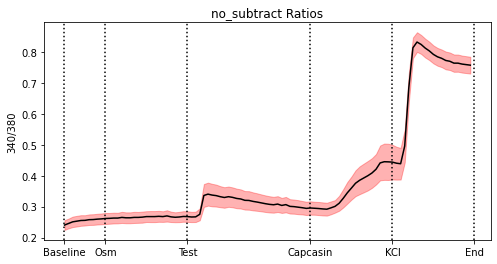

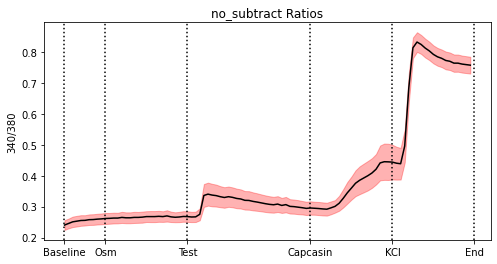

In [79]:
test = group_window()
test.mainloop()

In [22]:
test = main_window('poop')


In [23]:
test.mainloop()

   Unnamed: 0      name  time  measurement  direction  threshold  \
0           0  Baseline     1            2         -1        1.0   
1           1       Osm     2            2          2        0.4   
2           2      Test     3            3          1        0.4   
3           3  Capcasin     2            3          1        0.4   
4           4       KCl     2            3          1        0.4   

   thresh_check  ratio  chooser  
0             1      1        0  
1             0     -1        0  
2             1     -1        0  
3             1     -1        0  
4             1     -1        1  


,4,5,7,11,12,13,14,15,17,20,24
0,0.23,0.15,0.20,0.17,0.36,0.29,0.16,0.18,0.23,0.21,0.24
1,0.23,0.16,0.20,0.18,0.37,0.29,0.17,0.18,0.23,0.22,0.25
2,0.23,0.16,0.21,0.18,0.38,0.30,0.17,0.18,0.24,0.22,0.26
3,0.23,0.16,0.21,0.18,0.38,0.30,0.17,0.18,0.24,0.22,0.26
4,0.24,0.16,0.21,0.18,0.38,0.31,0.17,0.19,0.24,0.23,0.26
...,...,...,...,...,...,...,...,...,...,...,...
95,0.86,0.83,0.66,0.79,1.88,1.61,1.04,0.61,0.59,0.56,1.17
96,0.86,0.83,0.66,0.79,1.83,1.69,1.03,0.60,0.60,0.56,1.14
97,0.85,0.83,0.66,0.79,1.95,1.51,1.03,0.60,0.58,0.56,1.11
98,0.85,0.83,0.66,0.79,1.76,1.57,1.02,0.60,0.58,0.56,1.17


In [67]:
cs.ratio_dat.shape

(103, 28)

In [56]:
log_file = "no_subtract.LOG"
num_LPs = 5
LP_length = [1,2,3,2,2] 
LP_IDs = ["Baseline", "Osm", "Test", "Capsaicin", "KCl"]
metrics = [2, 2, 1, 3, 3]
thresholds = [1, 0.4, 0.4, 3, 0.4]
direction = [-1, 0, 0, 1, 1]
r = [1, -1, -1, -1, -1]
tc = [1, 0, 0, 1, 1]
sample_rate = 10 # images per minute
chooser = [1, 0, 0, 0, 1]
lp_frames = [i * sample_rate for i in LP_length]


exp_params = {"lp_frames":lp_frames, "sample_rate":sample_rate, "ids":LP_IDs, "metrics": metrics, "threshold": thresholds, 
                          "direction": direction, 'ratio': r, 'tc': tc, 'chooser':chooser}


cs = coverslip(log_file, exp_params)
cs.process_coverslip()

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


AttributeError: 'Line2D' object has no property 'ax'

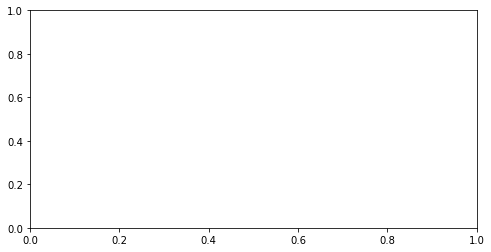

In [57]:
cs.plot_delta(1)